In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
import json

from pyspark.sql import SparkSession
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('paper')

In [3]:
flat_dir = '/data/repos/zoobot/data/decals/classifications/streaming/flat'
assert os.path.isdir(flat_dir)

In [4]:
flat_files = [os.path.join(flat_dir, x) for x in os.listdir(flat_dir) if x.endswith('json')]
len(flat_files)

791

In [5]:
def load_flat_responses(file_loc):
    with open(file_loc, 'r') as f:
        return pd.DataFrame([json.loads(x) for x in f.readlines()])

In [6]:
file_loc = flat_files[-5]
load_flat_responses(file_loc).head()

,created_at,user_id,subject_id,classification_id,question,response
0,2018-05-03T10:19:08.905+01:00,1774854,20925663,105626844,smooth-or-featured,smooth
1,2018-05-03T10:19:08.905+01:00,1774854,20925663,105626844,how-rounded,round
2,2018-05-03T10:19:08.905+01:00,1774854,20925663,105626844,merging,neither-v1
3,2018-05-03T10:19:15.802+01:00,1774854,20926661,105626865,smooth-or-featured,smooth
4,2018-05-03T10:19:15.802+01:00,1774854,20926661,105626865,how-rounded,round


In [7]:
file_loc

'/data/repos/zoobot/data/decals/classifications/streaming/flat/part-00047-2780185b-9a4d-4d97-802d-eb3ff4c1cfb0-c000.json'

In [8]:
# file_dfs = [load_flat_responses(file_loc) for file_loc in flat_files]

In [9]:
spark = None
if not spark:
    spark = SparkSession \
    .builder \
    .appName("aggregate") \
    .getOrCreate()

In [10]:
flat_df = spark.read.json(file_loc)

In [11]:
flat_df.printSchema()

root
 |-- classification_id: string (nullable = true)
 |-- created_at: string (nullable = true)
 |-- question: string (nullable = true)
 |-- response: string (nullable = true)
 |-- subject_id: string (nullable = true)
 |-- user_id: string (nullable = true)



In [12]:
schema = flat_df.schema

In [13]:
flat_dir_rel = '../data/decals/classifications/streaming/flat'
# !ls {flat_dir_rel}

In [14]:
print('Reading flattened responses (this will take a few minutes)')
df = spark.read.json(flat_dir_rel, schema=schema)  # must be a relative path to dir, not absolute path. Unclear why.
# print('Total responses: {}'.format(df.count()))

Reading flattened responses (this will take a few minutes)
Total responses: 18840495


In [15]:
smooth_q = df.filter(df.question == 'smooth-or-featured')

In [16]:
# this will show that there are many (1.9 million) duplicate top-level classifications

In [17]:
# smooth_q.count()

In [18]:
# smooth_q_grouped = smooth_q.groupby('subject_id').agg({'classification_id': 'count'})

In [19]:
# results = smooth_q_grouped.collect()

In [20]:
# results_df = pd.DataFrame(data=results, columns=['subject_id', 'classifications'])
# len(results_df)

In [21]:
# results_df['classifications'].hist(bins=50)

In [22]:
# results_df.query('classifications < 100').hist(bins=50)

In [23]:
# len(results_df.query('classifications <= 5'))

In [24]:
# classification_id_counts = smooth_q.groupby('classification_id').count().collect()

In [25]:
# class_counts_df = pd.DataFrame(data=classification_id_counts, columns=['classification_id', 'count'])

In [26]:
# class_counts_df['count'].value_counts()

But no duplicates for within a recent single file

In [27]:
# single_file_c_counts_df = pd.DataFrame(
#     data=flat_df.filter(flat_df.question == 'smooth-or-featured').groupby('classification_id').count().collect(),
#     columns=['classification_id', 'count']
# )

In [28]:
# single_file_c_counts_df['count'].value_counts()

Join with subject table to check retirement_limit metadata

In [29]:
smooth_q_dedup = smooth_q.drop_duplicates(subset=['classification_id', 'question', 'response'])

In [30]:
subjects_dir = '../data/decals/classifications/streaming/subjects'
subjects = spark.read.json(subjects_dir)

In [31]:
subjects.printSchema()

root
 |-- iauname: string (nullable = true)
 |-- retirement_limit: long (nullable = true)
 |-- subject_id: string (nullable = true)
 |-- subject_url: string (nullable = true)
 |-- upload_date: string (nullable = true)
 |-- uploader: string (nullable = true)



In [32]:
# subjects.count()

In [33]:
subjects_dedup = subjects.drop_duplicates(subset=['subject_id'])

In [34]:
# subjects_dedup.count()

In [35]:
subjects_df = subjects_dedup.collect()


In [36]:
smooth_q_df = smooth_q_dedup.collect()

Pandas from here!

In [41]:
subjects_col = subjects_df
smooth_q_col = smooth_q_df
# TODO bad naming above

In [44]:
subjects_col[0].asDict()

{'iauname': 'J100708.77+003701.0',
 'retirement_limit': None,
 'subject_id': '20243375',
 'subject_url': 'https://panoptes-uploads.zooniverse.org/production/subject_location/55164559-1379-4575-a77b-749a2b67d823.png',
 'upload_date': None,
 'uploader': None}

In [47]:
subjects_df = pd.DataFrame(data=[x.asDict() for x in subjects_col])
smooth_q_df = pd.DataFrame(data=[x.asDict() for x in smooth_q_col])

In [48]:
subjects_df.head()

,iauname,retirement_limit,subject_id,subject_url,upload_date,uploader
0,J100708.77+003701.0,NaN,20243375,https://panoptes-uploads.zooniverse.org/produc...,None,None
1,J100046.35+001229.0,NaN,20530055,https://panoptes-uploads.zooniverse.org/produc...,2018-03-22,None
2,J101549.19-001047.5,NaN,20530674,https://panoptes-uploads.zooniverse.org/produc...,2018-03-22,None
3,J101802.15-002527.7,NaN,20530881,https://panoptes-uploads.zooniverse.org/produc...,2018-03-22,None
4,J102255.98-005724.8,NaN,20530984,https://panoptes-uploads.zooniverse.org/produc...,2018-03-22,None


In [49]:
smooth_q_df.head()

,classification_id,created_at,question,response,subject_id,user_id
0,100005922,2018-04-03T01:04:13.496+01:00,smooth-or-featured,featured-or-disk,20531782,1717874
1,100009364,2018-04-03T01:37:35.820+01:00,smooth-or-featured,smooth,20531914,1616840
2,100012701,2018-04-03T02:01:05.252+01:00,smooth-or-featured,featured-or-disk,20532832,6641
3,100012845,2018-04-03T02:01:53.968+01:00,smooth-or-featured,smooth,20532538,1266721
4,100012941,2018-04-03T02:02:33.130+01:00,smooth-or-featured,smooth,20529989,None


In [65]:
len(smooth_q_df)

2694361

In [53]:
active_subjects = subjects_df[~pd.isnull(subjects_df['retirement_limit'])]

In [54]:
len(active_subjects)

51104

In [55]:
active_subjects['retirement_limit'].value_counts()

3.0     34781
40.0    15871
10.0      452
Name: retirement_limit, dtype: int64

In [ ]:
# of these, 5000 have actually had 40 and another 5000 have had about 15

In [100]:
class_agg = smooth_q_df.groupby('subject_id').agg({'classification_id': 'count'})

In [69]:
class_agg['classification_id']

subject_id
20529779    40
20529780    40
20529781    40
20529782    40
20529783    38
            ..
36258917     2
36258918     3
36258919     3
36258920     2
36258921     1
Name: classification_id, Length: 105074, dtype: int64

In [70]:
class_and_active = pd.merge(class_agg, active_subjects, how='inner', on='subject_id')

In [73]:
class_and_active['actual_classifications'] = class_and_active['classification_id']
del class_and_active['classification_id']

In [74]:
class_and_active.head()

,subject_id,iauname,retirement_limit,subject_url,upload_date,uploader,actual_classifications
0,32396055,J094651.40-010228.5,3.0,https://panoptes-uploads.zooniverse.org/produc...,2019-04-12,None,22
1,32396057,J094744.18-004013.4,3.0,https://panoptes-uploads.zooniverse.org/produc...,2019-04-12,None,27
2,32396058,J094751.74-003242.0,3.0,https://panoptes-uploads.zooniverse.org/produc...,2019-04-12,None,13
3,32396060,J094751.24-004533.5,3.0,https://panoptes-uploads.zooniverse.org/produc...,2019-04-12,None,14
4,32396062,J094726.35-004832.0,3.0,https://panoptes-uploads.zooniverse.org/produc...,2019-04-12,None,18


In [86]:
class_and_active['upload_date'] = pd.to_datetime(class_and_active['upload_date'])

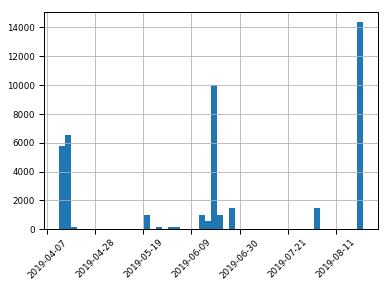

In [90]:
class_and_active['upload_date'].hist(bins=50)
_ = plt.xticks(rotation=45)

In [92]:
class_and_active = class_and_active[class_and_active['upload_date'] < pd.to_datetime('2019-06-30')]

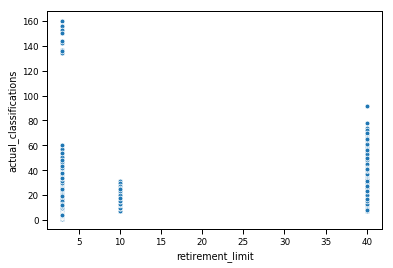

In [93]:
sns.scatterplot(data=class_and_active, x='retirement_limit', y='actual_classifications')

(0.0, 50.0)

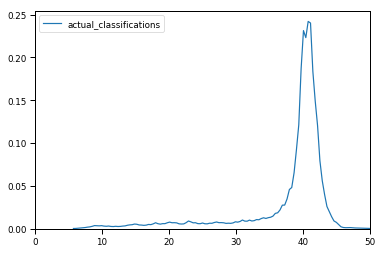

In [105]:
active = class_and_active.query('retirement_limit == 40').query('actual_classifications < 50')
sns.kdeplot(active['actual_classifications'])
plt.xlim([0., 50.])

(0.0, 50.0)

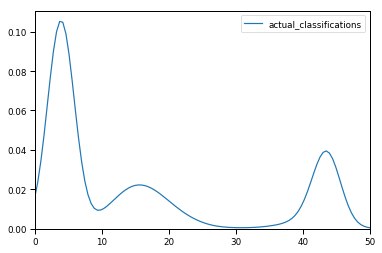

In [106]:
random = class_and_active.query('retirement_limit == 3').query('actual_classifications < 50')
sns.kdeplot(random['actual_classifications'])
plt.xlim([0., 50.])

In [102]:
len(random.query('actual_classifications > 30'))

5000

In [103]:
random.query('actual_classifications > 30')['upload_date'].value_counts()

2019-04-16    4990
2019-06-20       5
2019-04-12       5
Name: upload_date, dtype: int64

In [104]:
random.query('actual_classifications > 9').query('actual_classifications < 30')['upload_date'].value_counts()

2019-04-12    5124
2019-06-20       6
2019-04-16       3
Name: upload_date, dtype: int64

In [107]:
random.query('actual_classifications < 9')['upload_date'].value_counts()

2019-06-20    9980
2019-05-21     990
2019-06-17     599
2019-04-12      86
Name: upload_date, dtype: int64

(0.0, 50.0)

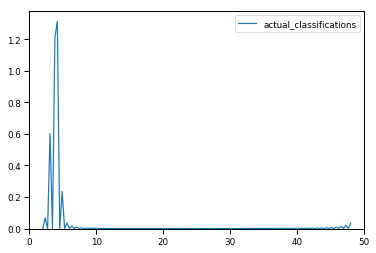

In [215]:
random = class_and_active.query('retirement_limit == 3').query('actual_classifications < 50')
sns.kdeplot(random[random['upload_date'] > pd.to_datetime('2019-05-21')]['actual_classifications'])
plt.xlim([0., 50.])

All the galaxies uploaded since 21/05/2019 have been getting a suitably small number of classifications, so the system seems to be working

In [152]:
responses_and_active = pd.merge(smooth_q_df, active_subjects, how='inner', on='subject_id')

In [158]:
len(smooth_q_df), len(responses_and_active)

(2694361, 655025)

In [153]:
responses_and_active = responses_and_active[~pd.isnull(responses_and_active['upload_date'])]

In [154]:
responses_and_active['upload_date']

0         2019-04-12
1         2019-04-12
2         2019-04-12
3         2019-04-12
4         2019-04-12
             ...    
665446    2019-08-23
665450    2019-08-23
665451    2019-08-23
665455    2019-08-23
665456    2019-08-23
Name: upload_date, Length: 655025, dtype: object

In [164]:
# responses_and_active['upload_date'] = pd.to_datetime(responses_and_active['upload_date']).dt.date
responses_and_active['created_at'] = pd.to_datetime(responses_and_active['created_at'], utc=True).dt.date

In [176]:
responses_and_active.query('retirement_limit == 40')['created_at']

40482     2019-05-22
40483     2019-05-30
40484     2019-06-02
40485     2019-06-10
40486     2019-06-05
             ...    
651224    2019-08-16
651225    2019-09-05
651226    2019-08-04
651227    2019-08-06
651228    2019-08-19
Name: created_at, Length: 272865, dtype: object

In [189]:
random_classifications = responses_and_active.query('retirement_limit == 3').groupby('created_at').agg({'classification_id': 'count'}).reset_index()
priority_classifications = responses_and_active.query('retirement_limit == 40').groupby('created_at').agg({'classification_id': 'count'}).reset_index()

In [190]:
random_classifications.head()

,created_at,classification_id
0,2019-04-12,23
1,2019-04-13,1836
2,2019-04-14,3693
3,2019-04-15,5181
4,2019-04-16,5899


(0, 12000)

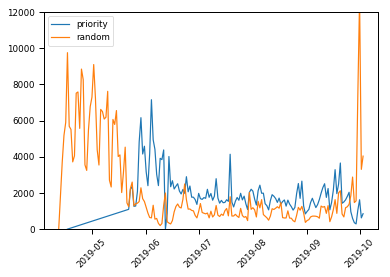

In [194]:
plt.plot(priority_classifications['created_at'], priority_classifications['classification_id'], label='priority')
plt.plot(random_classifications['created_at'], random_classifications['classification_id'], label='random')
plt.legend()
plt.xticks(rotation=45)
plt.ylim([0, 12000])

In [211]:
temp = responses_and_active.groupby('subject_id').agg({'classification_id': 'count', 'created_at': 'first'}).reset_index()
actual_random_classifications = temp.query('classification_id < 6').groupby('created_at').agg({'classification_id': 'count'}).reset_index()
actual_priority_classifications = temp.query('classification_id > 35').groupby('created_at').agg({'classification_id': 'count'}).reset_index()

In [212]:
actual_random_classifications.head()

,created_at,classification_id
0,2019-05-21,3
1,2019-05-22,62
2,2019-05-23,108
3,2019-05-24,133
4,2019-05-25,57


In [213]:
actual_priority_classifications.head()

,created_at,classification_id
0,2019-04-16,118
1,2019-04-17,229
2,2019-04-18,145
3,2019-04-19,140
4,2019-04-20,77


(array([737180., 737211., 737241., 737272., 737303., 737333.]),
 <a list of 6 Text xticklabel objects>)

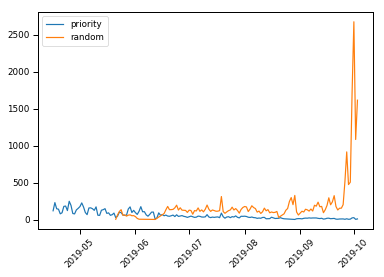

In [214]:
plt.plot(actual_priority_classifications['created_at'], actual_priority_classifications['classification_id'], label='priority')
plt.plot(actual_random_classifications['created_at'], actual_random_classifications['classification_id'], label='random')
plt.legend()
plt.xticks(rotation=45)
# plt.ylim([0, 12000])